# Performing a Basic Climate Analysis with NARCliM2.0 over Western Australia
## Analysis Question: How is maximum air temperature changing seasonally across Western Australia in 2015 under SSP1-2.6?

This notebook demonstrates a complete workflow:

Load NARCliM2.0 tasmax data (Kelvin)

Subset to Western Australia

Calculate seasonal temperature summaries

Export results for GIS analysis



## Method overview

The analysis follows five main steps:

1. **Load and inspect** the CORDEX/WRF dataset.  
2. **Subset Western Australia** using a geographic bounding box applied to the 2-D latitude and longitude fields.  
3. **Visualise spatial patterns** using Cartopy with explicit map projections.  
4. **Compute seasonal climatologies and anomalies** relative to the annual mean.  
5. **Regrid results** to a regular lat/lon grid for export and extract a **Perth time series** for local-scale interpretation.

This approach ensures that all spatial results are geographically consistent and suitable for mapping and external use.


## Load Packages

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # Hide all warnings

import xesmf as xe
import xarray as xr
import numpy as np
import rioxarray
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Connect to NARCliM2.0 data



In [29]:
# Base URL for NARCliM2.0 monthly tasmax data (AUS-18 CORDEX domain)
BASE_URL = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/"
    "NARCliM2-0/output-CMIP6/DD"
)

domain = "AUS-18"
organisation = "NSW-Government"

gcm = "ACCESS-ESM1-5"
rcm = "NARCliM2-0-WRF412R3"
experiment = "ssp126"
variant = "r6i1p1f1"

frequency = "mon"
variable = "tasmax"
version = "v1-r1"

file_url = (
    f"{BASE_URL}/{domain}/{organisation}/"
    f"{gcm}/{experiment}/{variant}/"
    f"{rcm}/{version}/{frequency}/{variable}/latest/"
    f"{variable}_{domain}_{gcm}_{experiment}_{variant}_"
    f"{organisation}_{rcm}_{version}_{frequency}_201501-201512.nc"
)

ds = xr.open_dataset(file_url)

ds


<xarray.Dataset> Size: 10MB
Dimensions:    (time: 12, rlat: 321, rlon: 497, bnds: 2, crs: 1)
Coordinates:
  * time       (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T1...
  * rlat       (rlat) float64 3kB -22.88 -22.71 -22.53 ... 33.08 33.26 33.44
  * rlon       (rlon) float64 4kB -178.5 -178.3 -178.2 ... 178.2 178.3 178.5
  * crs        (crs) int32 4B 2143289344
    time_bnds  (time, bnds) datetime64[ns] 192B ...
    height     float64 8B ...
    lat        (rlat, rlon) float64 1MB ...
    lon        (rlat, rlon) float64 1MB ...
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, rlat, rlon) float32 8MB ...
Attributes: (12/43)
    project_id:                      CORDEX
    comment:                         DPIE version of WRF4.1.2
    DPIE_WRF_HASH:                   a051fdc73749349fd244ce8e596088a372bdb0c5
    wrf_options:                     sst_update & tmn_update
    frequency:                       mon
    git_url_postprocessing:          git@bitbucket.org:oehcas/cordex_postproc...
    ...                              ...
    wrf_schemes_mp_physics:          Thompson, Gregory, Paul R. Field, Roy M....
    wrf_schemes_bl_pbl_physics:      Nakanishi, M., and H. Niino, 2006: An im...
    wrf_schemes_cu_physics:          Betts-Miller-Janjic; Janjic (1994, MWR; ...
    references:                      Include in publications citations to the...
    NCO:                             netCDF Operators version 5.2.4 (Homepage...
    history:                         Tue Jul 30 11:27:20 2024: ncatted -O -a ...

## Subsetting Western Australia
The NARCliM2.0 dataset is stored on a rotated model grid.
As a result, standard coordinate selection methods (e.g. .sel(lon=…, lat=…)) are not appropriate.

Instead, Western Australia is extracted by:

using the 2-D latitude and longitude fields (lat, lon),
defining a geographic bounding box for WA, and
applying a mask that keeps only grid cells whose real-world coordinates fall inside this region.
This ensures that all subsequent calculations represent the correct geographic area.

In [47]:
# Western Australia bounding box (degrees)
central_lat = -24.5
central_lon = 121.0
buffer = 10.0

study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

print(f"Study area: lon {study_area_lon[0]:.1f}° to {study_area_lon[1]:.1f}°E")
print(f"           lat {study_area_lat[0]:.1f}° to {study_area_lat[1]:.1f}°S")


Study area: lon 111.0° to 131.0°E
           lat -34.5° to -14.5°S


In [31]:
da = ds["tasmax"]

# --- WA bounding box ---
lon_min, lon_max = 112, 129
lat_min, lat_max = -36, -13

# --- real coordinates (2-D) ---
lat2d = ds["lat"]
lon2d = ds["lon"]

# --- normalise longitude to 0–360 ---
lon2d_360 = (lon2d + 360) % 360

# --- build mask ---
wa_mask = (
    (lon2d_360 >= lon_min) & (lon2d_360 <= lon_max) &
    (lat2d >= lat_min) & (lat2d <= lat_max)
)

# --- apply mask ---
tasmax_wa = da.where(wa_mask)

print("Valid cells:", int(wa_mask.sum()))


Valid cells: 11515


## Mapping approach

Spatial visualisations are produced using **Cartopy** with the `PlateCarree` projection.

Because the data are defined on a rotated grid, maps are generated using:

- `pcolormesh(lon, lat, data)`  
- with an explicit `transform=ccrs.PlateCarree()` argument  

This guarantees that values are plotted at their true geographic locations and prevents the empty or misplaced maps that occur when plotting rotated-grid data with default routines.


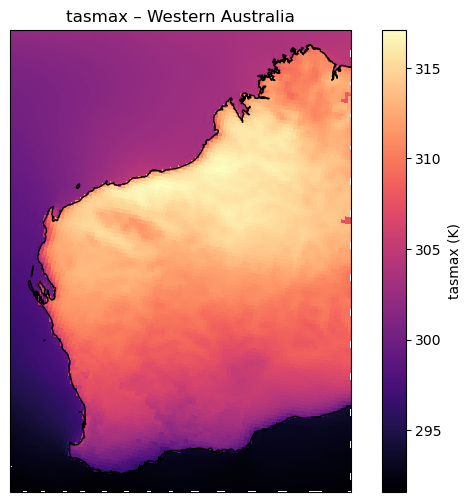

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# --- pick one time slice to test ---
da_plot = tasmax_wa.isel(time=0)

# real coordinates
lat2d = ds["lat"]
lon2d = ds["lon"]

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# plot using real lat/lon
pcm = ax.pcolormesh(
    lon2d, lat2d, da_plot,
    transform=ccrs.PlateCarree(),
    shading="auto",
    cmap="magma"
)

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# focus on WA
ax.set_extent([112, 129, -36, -13], crs=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, label="tasmax (K)")
plt.title("tasmax – Western Australia")
plt.show()



## Step 3: Plot raw data


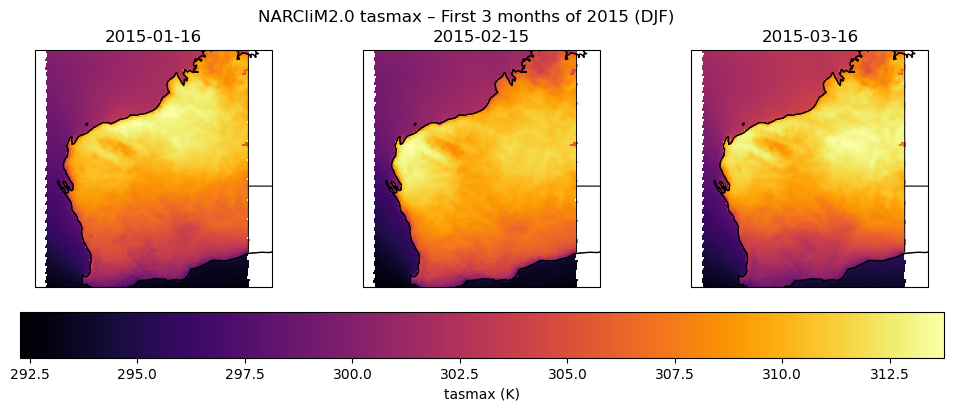

In [33]:
# Plot first 3 months (DJF summer) — CORRECT WAY

time_step = slice(0, 3)

lat2d = ds["lat"]
lon2d = ds["lon"]

fig, axes = plt.subplots(
    1, 3, figsize=(12,4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for i, ax in enumerate(axes):
    da_plot = tasmax_wa.isel(time=i)

    pcm = ax.pcolormesh(
        lon2d, lat2d, da_plot,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="inferno"
    )

    ax.set_extent(
        [study_area_lon[0], study_area_lon[1],
         study_area_lat[0], study_area_lat[1]],
        crs=ccrs.PlateCarree()
    )

    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.set_title(str(tasmax_wa.time.values[i])[:10])

plt.colorbar(pcm, ax=axes, orientation="horizontal",
             pad=0.08, label="tasmax (K)")

plt.suptitle("NARCliM2.0 tasmax – First 3 months of 2015 (DJF)")
plt.show()


## Seasonal climatology and anomalies

To examine seasonal behaviour, the following quantities are computed:

- **Seasonal mean temperature**:  
  the average `tasmax` for each climatological season (DJF, MAM, JJA, SON).

- **Annual mean temperature**:  
  the average across all months of 2015.

- **Seasonal anomaly**:  
  the difference between each seasonal mean and the annual mean.

These anomalies highlight how each season departs from typical annual conditions and provide a clear view of seasonal contrasts across Western Australia.


In [34]:
# Calculate seasonal means (DJF, MAM, JJA, SON)
seasonal_tasmax = tasmax_wa.groupby("time.season").mean("time")

# Calculate anomalies relative to annual mean
annual_mean = tasmax_wa.mean("time")
seasonal_anomaly = seasonal_tasmax - annual_mean

print("Seasons calculated:", list(seasonal_anomaly.season.values))


Seasons calculated: ['DJF', 'JJA', 'MAM', 'SON']


## Plot Seasonal Anomalities

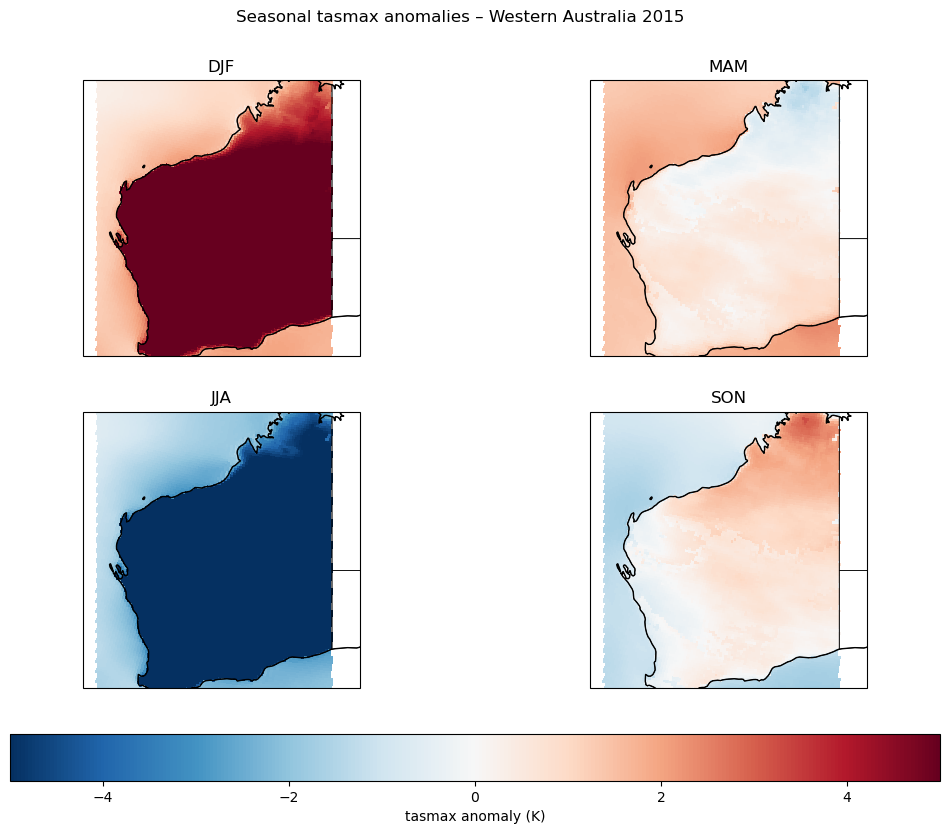

In [35]:
# --- Plot all seasons (CORRECT for WRF / rotated grid) ---

lat2d = ds["lat"]
lon2d = ds["lon"]

fig, axes = plt.subplots(
    2, 2, figsize=(12,10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

axes = axes.flatten()
seasons = ["DJF", "MAM", "JJA", "SON"]

for ax, s in zip(axes, seasons):

    da_s = seasonal_anomaly.sel(season=s)

    pcm = ax.pcolormesh(
        lon2d, lat2d, da_s,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="RdBu_r",
        vmin=-5, vmax=5
    )

    # map styling
    ax.set_extent(
        [study_area_lon[0], study_area_lon[1],
         study_area_lat[0], study_area_lat[1]],
        crs=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.set_title(s)

# shared colorbar
cbar = plt.colorbar(
    pcm, ax=axes,
    orientation="horizontal",
    pad=0.06,
    label="tasmax anomaly (K)"
)

plt.suptitle("Seasonal tasmax anomalies – Western Australia 2015", y=0.95)
plt.show()


## Regridding to a regular latitude–longitude grid

While analysis and mapping are performed on the native WRF grid, spatial exports (e.g. for GIS or web mapping) require data on a **regular lat/lon grid**.

Seasonal anomalies are therefore regridded using bilinear interpolation onto a uniform grid covering Western Australia.  
This step enables:

- simple plotting with standard tools,  
- compatibility with GIS software, and  
- consistent export to common spatial formats.

The regridded product forms the basis for all exported spatial layers.


In [37]:
# -------------------------------------------------
# Regrid seasonal anomalies to lat/lon grid
# -------------------------------------------------

# target regular grid over Western Australia
lon_new = np.arange(112, 129.05, 0.05)
lat_new = np.arange(-36, -12.95, 0.05)

ds_out = xr.Dataset(
    {
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    }
)

# build regridder (WRF → regular grid)
regridder = xe.Regridder(
    seasonal_anomaly,
    ds_out,
    method="bilinear",
    periodic=False
)


seasonal_anom_ll = regridder(seasonal_anomaly)
print(seasonal_anom_ll)


<xarray.DataArray (season: 4, lat: 461, lon: 342)> Size: 3MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,  0.6571049 , ...,         nan,
                 nan,         nan],
        [        nan,         nan,  0.669083  , ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
  

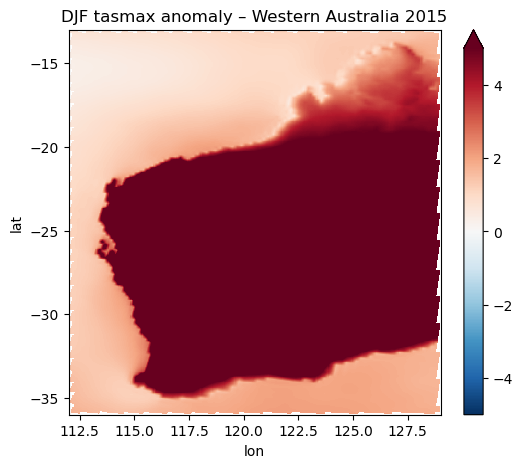

In [42]:
seasonal_anom_ll.sel(season="DJF").plot(
    cmap="RdBu_r",
    vmin=-5, vmax=5,
    figsize=(6,5)
)
plt.xlim(112, 129)
plt.ylim(-36, -13)
plt.title("DJF tasmax anomaly – Western Australia 2015")
plt.show()


## Exported products

Two types of outputs are generated from the analysis:

1. **Seasonal anomaly fields**  
   Regridded seasonal anomalies are saved in NetCDF format, preserving:
   - latitude and longitude coordinates,  
   - seasonal dimension, and  
   - full metadata.

   These files can be opened directly in GIS platforms (QGIS, ArcGIS), scientific viewers (Panoply), or used in downstream modelling workflows.

2. **Perth temperature time series**  
   A representative point time series is extracted for the Perth region by:
   - computing distances on the 2-D latitude/longitude grid, and  
   - selecting the grid cell closest to the target location.

   The resulting time series is exported as a NetCDF file for local-scale analysis and comparison with observations.


In [41]:
# Export seasonal anomalies as NetCDF
seasonal_anom_ll.to_netcdf("tasmax_anomaly_WA_2015.nc")
print("Exported: tasmax_anomaly_WA_2015.nc")


Exported: tasmax_anomaly_WA_2015.nc


In [40]:
# target location: Perth
target_lon, target_lat = 116.0, -32.0

lat2d = ds["lat"]
lon2d = ds["lon"]

# squared distance
dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2

# closest grid point
idx = dist2.argmin(dim=("rlat", "rlon"))
rlat_idx = idx["rlat"].item()
rlon_idx = idx["rlon"].item()

perth_ts = tasmax_wa.isel(rlat=rlat_idx, rlon=rlon_idx)

perth_ts.to_netcdf("perth_tasmax_2015.nc")
print("Exported: perth_tasmax_2015.nc")


Exported: perth_tasmax_2015.nc


## Interpretation

The seasonal anomaly patterns reveal clear spatial and temporal contrasts in maximum temperature across Western Australia:

- **Summer (DJF)** shows the strongest positive anomalies, particularly in northern and inland regions, reflecting intense seasonal heating.  
- **Winter (JJA)** exhibits widespread negative anomalies, consistent with cooler conditions across the state.  
- **Autumn (MAM)** and **spring (SON)** represent transitional regimes, with mixed spatial patterns as the climate shifts between warm and cool seasons.

The Perth time series demonstrates a pronounced seasonal cycle, with peak temperatures in summer and minimum values in winter, aligning with the broader regional patterns observed in the spatial fields.


## Summary

This notebook demonstrates a complete, spatially consistent workflow for analysing regional climate model output on a rotated grid.

Key strengths of the approach include:
- correct handling of WRF grid geometry,  
- robust seasonal anomaly computation,  
- accurate cartographic visualisation, and  
- production of reusable spatial and point-based climate products.

The methods used here provide a reliable foundation for extending the analysis to additional years, variables, or climate scenarios.


**Extensions to try**    
Change time period: Modify file_url for different years

Different variable: Replace tasmax with tasmin or pr

Different scenario: Use ssp370 instead of ssp126

Smaller region: Adjust buffer for Pilbara, Kimberley, etc.